<a href="https://colab.research.google.com/github/ZohebAbai/Deep-Learning-Projects/blob/master/JAX_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
print(jax.__version__)

0.3.8


In [2]:
import jax
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

## Pmap: Replicate computation across devices/cores

It automatically distributes computation across all the current devices/cores and handles all the communication between them.

In [3]:
from jax import random, pmap
import jax.numpy as jnp

In [4]:
# Create 8 random 4000 x 4000 matrices, one per TPU core
keys = random.split(random.PRNGKey(0), 8)
mats = pmap(lambda key: random.normal(key, (4000, 4000)))(keys)

# Run a local matmul on each device in parallel (no data transfer)
result = pmap(lambda x: jnp.dot(x, x.T))(mats)  # result.shape is (8, 4000, 4000)

# Compute the mean on each device in parallel send to host device
res = pmap(jnp.mean)(result)
print(res)
print(type(res))

[1.0199394  0.9668201  1.0053902  0.99666095 1.0342438  1.0092341
 0.97426695 0.9763453 ]
<class 'jax.interpreters.pxla._ShardedDeviceArray'>


`ShardedDeviceArray` is the structure that handles the parallel execution

In [5]:
%timeit -n 1 -r 5 jnp.dot(mats[0], mats[0]).block_until_ready()

The slowest run took 90.95 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 7.78 ms per loop


In [6]:
%timeit -n 1 -r 5 pmap(jnp.dot)(mats, mats).block_until_ready()

The slowest run took 82.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 8.85 ms per loop


Just a slight overhead.

**To take advantage of cores communicating to each other, in addition to expressing pure maps, you can use fast [collective communication operations](https://jax.readthedocs.io/en/latest/jax.lax.html#parallel-operators) between devices:**

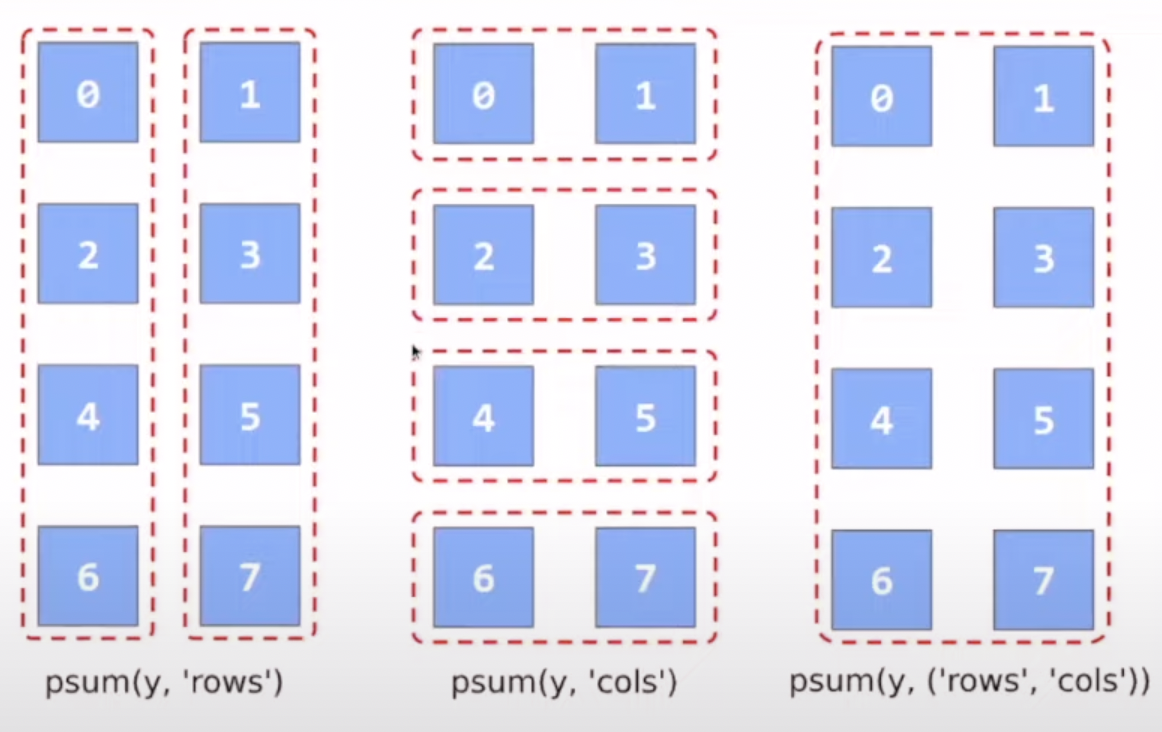

In [7]:
from functools import partial
from jax.lax import psum

@partial(pmap, axis_name='rows')
@partial(pmap, axis_name='cols')
def f(x):
    row_sum = psum(x, 'rows')
    col_sum = psum(x, 'cols')
    total_sum = psum(x, ('rows', 'cols'))
    return row_sum, col_sum, total_sum

x = jnp.arange(8.).reshape((4,2))
a,b,c = f(x)

print(f"input:\n {x}")
print(f"row sum:\n {a}")
print(f"col sum:\n {b}")
print(f"total sum:\n {c}")

input:
 [[0. 1.]
 [2. 3.]
 [4. 5.]
 [6. 7.]]
row sum:
 [[12. 16.]
 [12. 16.]
 [12. 16.]
 [12. 16.]]
col sum:
 [[ 1.  1.]
 [ 5.  5.]
 [ 9.  9.]
 [13. 13.]]
total sum:
 [[28. 28.]
 [28. 28.]
 [28. 28.]
 [28. 28.]]


## Composability of JAX transformations


In [8]:
from jax import grad

@pmap
def f(x):
  y = jnp.sin(x)
  @pmap
  def g(z):
    return jnp.cos(z) * jnp.tan(y.sum()) * jnp.tanh(x).sum()
  return grad(lambda w: jnp.sum(g(w)))(x)

print(f(x))

print("\n")

print(grad(lambda x: jnp.sum(f(x)))(x))

[[ 0.         -0.7170853 ]
 [-3.1085174  -0.4824318 ]
 [10.366636   13.135289  ]
 [ 0.22163185 -0.52112055]]


[[ -3.2369728  -1.6356447]
 [  4.757248   11.606952 ]
 [-98.524414   42.76499  ]
 [ -1.6007165  -1.2568436]]




[Tweet](
https://twitter.com/DavidDuvenaud/status/1284181673496776706?s=20&t=uo230aU8Gbrl6whG_M4Vww) shared by [David Duvenaud](https://twitter.com/DavidDuvenaud)

Here, JAX jitted the gradient of auto-minibatched ode solutions of jets of a neural net!